# Exploring netCDF files with Python

First, we import the needed things from IPython, NumPy, Matplotlib and SciPy all at once with pylab. 

This can be done individually with "import modulename", "import modulename as alias" or import only the desired functions "from modulename import function".

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from netCDF4 import Dataset

In [3]:
f = Dataset("http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/"
            +".ERSST/.version4/.sst/dods")
f

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format UNDEFINED):
    Conventions: IRIDL
    dimensions(sizes): T(1941), X(180), Y(89), zlev(1)
    variables(dimensions): float32 Y(Y), float32 zlev(zlev), float32 X(X), float32 T(T), int16 sst(T,zlev,Y,X)
    groups: 

In [4]:
temp = f.variables['sst']
temp

<type 'netCDF4._netCDF4.Variable'>
int16 sst(T, zlev, Y, X)
    pointwidth: 1.0
    missing_value: -999
    scale_factor: 0.01
    units: Celsius_scale
    valid_min: -300
    long_name: Extended reconstructed sea surface temperature
    valid_max: 4500
    standard_name: sea_surface_temperature
    iridl:hasSemantics: iridl:SeaSurfaceTemperature
    expires: 1446422400
unlimited dimensions: 
current shape = (1941, 1, 89, 180)
filling off

In [5]:
!cd /Users/lsiqueira/Desktop/python_lunchbytes
!ls -lh ersst_v4.nc
ifile = 'ersst_v4.nc'

-rw-r-----@ 1 lsiqueira  staff    59M Oct 25 17:28 ersst_v4.nc


In [6]:
f = Dataset(ifile)
temp = f.variables['sst'][:].squeeze()
lats = f.variables['Y'][:]
lons = f.variables['X'][:]
f.close()

In [7]:
shape(temp)


(1941, 89, 180)

In [8]:
%%timeit
f = Dataset(ifile);
temp = f.variables['sst'][:].squeeze().mean(axis=0)

1 loops, best of 3: 638 ms per loop


/Users/lsiqueira/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


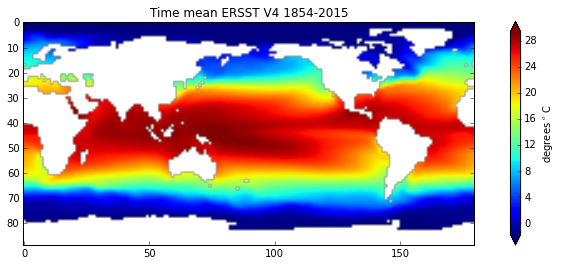

In [9]:
f = Dataset(ifile)
temp = f.variables['sst'][:].squeeze().mean(axis=0)
figure(figsize=(13, 4))
imshow(flipud(temp), cmap='jet')
title('Time mean ERSST V4 1854-2015')
colorbar(label='degrees $^o$C', extend='both');

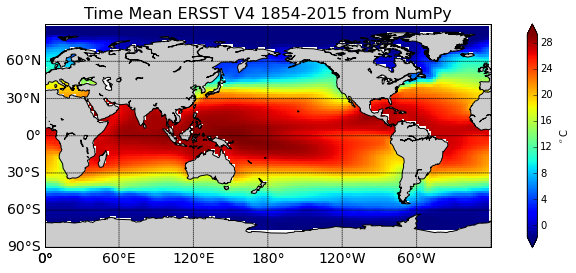

In [10]:
from mpl_toolkits.basemap import Basemap

figure(figsize=(13, 4))
m = Basemap(projection='cyl', resolution='c', llcrnrlon=0, llcrnrlat=-90,
            urcrnrlon=360, urcrnrlat=90)
x, y = m(*np.meshgrid(lons, lats))
clevs = np.linspace(-1, 30, 64)
cs = m.pcolormesh(x,y,temp, shading='flat', cmap=plt.cm.jet)
m.drawcoastlines()
m.drawparallels(arange(-90.,90.,30.), labels=[1,0,0,0], fontsize=14)
m.drawmeridians(arange(0.,360.,60.), labels=[0,0,0,1], fontsize=14)
m.fillcontinents()
colorbar(cs, label='$^o$C', extend='both')
plt.title('Time Mean ERSST V4 1854-2015 from NumPy', fontsize=16)


Install CDO Python bindings to use embeded CDO commands with "pip install cdo"

In [11]:
from cdo import *

In [12]:
cdo = Cdo()

In [13]:
cdo.sinfon(input=ifile)   

[u'File format: netCDF',
 u'-1 : Institut Source   Ttype    Levels Num  Gridsize Num Dtype : Parameter name',
 u'1 : unknown  unknown  instant       1   1     16020   1  I16  : sst',
 u'Grid coordinates :',
 u'1 : lonlat       > size      : dim = 16020  nx = 180  ny = 89',
 u'X         : first = 0  last = 358  inc = 2  degree_east  circular',
 u'Y         : first = -88  last = 88  inc = 2  degree_north',
 u'Vertical coordinates :',
 u'1 : generic            meters : 0',
 u'Time coordinate :  1941 steps',
 u'RefTime =  1960-01-01 00:00:00  Units = months  Calendar = 360_day',
 u'YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss',
 u'1854-01-16 00:00:00  1854-02-16 00:00:00  1854-03-16 00:00:00  1854-04-16 00:00:00',
 u'1854-05-16 00:00:00  1854-06-16 00:00:00  1854-07-16 00:00:00  1854-08-16 00:00:00',
 u'1854-09-16 00:00:00  1854-10-16 00:00:00  1854-11-16 00:00:00  1854-12-16 00:00:00',
 u'1855-01-16 00:00:00  1855-02-16 00:00:00  1855-03-16 00:00:00  

Compute the field time mean value using CDO and return it as a numpy array without writing nc file to disk.

In [14]:
%%timeit
cdo.timmean(input=ifile,returnCdf=True).variables['sst'][:] 

1 loops, best of 3: 1.24 s per loop


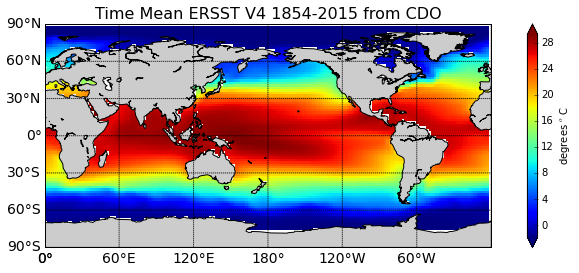

In [15]:
tavg_cdo = cdo.timmean(input=ifile,returnCdf=True).variables['sst'][:] 

figure(figsize=(13, 4))
m = Basemap(projection='cyl', resolution='c', llcrnrlon=0, llcrnrlat=-90,
            urcrnrlon=360, urcrnrlat=90)
x, y = m(*np.meshgrid(lons, lats))
clevs = np.linspace(-1, 30, 64)
cs = m.pcolormesh(x,y,tavg_cdo.squeeze(), shading='flat', cmap=plt.cm.jet)
m.drawcoastlines()
m.drawparallels((-90, -60, -30, 0, 30, 60, 90), labels=[1,0,0,0], fontsize=14)
m.drawmeridians((0, 60, 120, 180, 240, 300, 360), labels=[0,0,0,1], fontsize=14)
m.fillcontinents()
colorbar(cs, label='degrees $^o$C', extend='both')
plt.title('Time Mean ERSST V4 1854-2015 from CDO ', fontsize=16)


In [16]:
diff = tavg_cdo.squeeze() - temp
diff.max()


0.0050185128378537058

In [17]:
ifile = '20101221-JPL-L4UHfnd-GLOB-v01-fv04-MUR.nc'
f = Dataset(ifile)
temp = f.variables['analysed_sst']
temp

<type 'netCDF4._netCDF4.Variable'>
int16 analysed_sst(time, lat, lon)
    long_name: analysed sea surface temperature
    standard_name: sea_surface_foundation_temperature
    units: kelvin
    _FillValue: -32768
    add_offset: 298.15
    scale_factor: 0.001
    valid_min: -32767
    valid_max: 32767
unlimited dimensions: 
current shape = (1, 5097, 9102)
filling off

In [18]:
temp = f.variables['analysed_sst'][:].squeeze()
lats = f.variables['lat'][:]
lons = f.variables['lon'][:]
f.close()

In [19]:
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def make_map(llcrnrlon=-100, urcrnrlon=-50, llcrnrlat=15, urcrnrlat=50,
             projection='cyl', resolution='l', figsize=(10, 3.5), inset=True):
    
    m = Basemap(llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon,
                llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat,
                projection=projection, resolution=resolution)
    
    fig, ax = plt.subplots(figsize=figsize)
    m.drawcoastlines()
    m.bluemarble()
    meridians = np.arange(llcrnrlon, urcrnrlon + 2, 10)
    parallels = np.arange(llcrnrlat, urcrnrlat + 1, 10)
    m.drawparallels(parallels, linewidth=0, labels=[1, 0, 0, 0], fontsize=20)
    m.drawmeridians(meridians, linewidth=0, labels=[0, 0, 0, 1], fontsize=20)
    m.llcrnrlon = llcrnrlon
    m.urcrnrlon = urcrnrlon
    m.llcrnrlat = llcrnrlat
    m.urcrnrlat = urcrnrlat
    m.ax = ax

    if inset:
        axin = inset_axes(m.ax, width="45%", height="45%", loc=4)
        # Global inset map.
        inmap = Basemap(projection='ortho', lon_0=-60, lat_0=35,
                        ax=axin, anchor='NE')
        inmap.drawcountries(color='white')
        inmap.fillcontinents(color='gray')
        bx, by = inmap(m.boundarylons, m.boundarylats)
        xy = list(zip(bx, by))
        mapboundary = Polygon(xy, edgecolor='k', linewidth=1, fill=False)
        inmap.ax.add_patch(mapboundary)
    return fig, m

/Users/lsiqueira/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/lsiqueira/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/lsiqueira/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


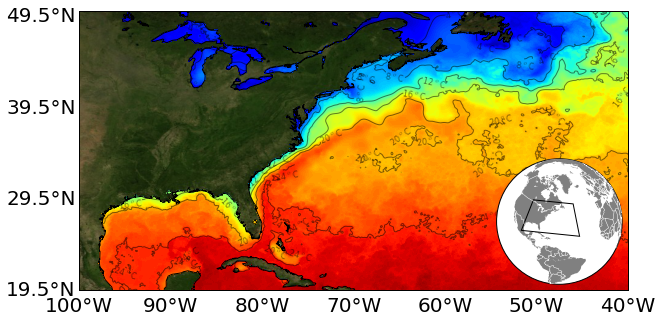

In [20]:
x, y = m(*np.meshgrid(lons, lats))
fig, m = make_map(llcrnrlon=-100, urcrnrlon=-40, llcrnrlat=19.5,
                  urcrnrlat=50, figsize=(15, 5))
clevs = np.linspace(0, 28, 128)
cs = m.contourf(x, y, temp-273.15, clevs, latlon=True, animated =True)
csc = m.contour(x, y, temp-273.15, colors='k',
                latlon=True, alpha=0.5)
_ = m.ax.clabel(csc, fmt='%1.0f $^o$C', fontsize=8, inline=1)

# Time Series analysis with Pandas (statistical package)

In [21]:
import pandas as pd
import numpy as np

In [22]:
pd.set_option('max_rows',15)

In [23]:
!wget http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii
!wget http://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii

--2015-10-28 17:16:31--  http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii
Resolving www.cpc.ncep.noaa.gov... 140.90.101.63
Connecting to www.cpc.ncep.noaa.gov|140.90.101.63|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725 (19K) [text/plain]
Saving to: 'monthly.ao.index.b50.current.ascii.2'

100%[======================================>] 19,725      12.0KB/s   in 1.6s   

2015-10-28 17:16:34 (12.0 KB/s) - 'monthly.ao.index.b50.current.ascii.2' saved [19725/19725]

--2015-10-28 17:16:34--  http://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii
Resolving www.cpc.ncep.noaa.gov... 140.90.101.63
Connecting to www.cpc.ncep.noaa.gov|140.90.101.63|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18936 (18K) [text/plain]
Saving to: 'norm.nao.monthly.b5001.current.ascii.2'

100%[======================================>] 18,936      23.3KB/s   in 0.8s   

2

In [24]:
ao = np.loadtxt('monthly.ao.index.b50.current.ascii')
ao

array([[  1.95000000e+03,   1.00000000e+00,  -6.03100000e-02],
       [  1.95000000e+03,   2.00000000e+00,   6.26810000e-01],
       [  1.95000000e+03,   3.00000000e+00,  -8.12750000e-03],
       ..., 
       [  2.01500000e+03,   7.00000000e+00,  -1.10790000e+00],
       [  2.01500000e+03,   8.00000000e+00,  -6.89020000e-01],
       [  2.01500000e+03,   9.00000000e+00,  -1.64510000e-01]])

In [25]:
dates = pd.date_range('1950-01', '2015-10', freq='M')
AO = pd.Series(ao[:,2], index=dates)
AO

1950-01-31   -0.060310
1950-02-28    0.626810
1950-03-31   -0.008127
1950-04-30    0.555100
1950-05-31    0.071577
1950-06-30    0.538570
1950-07-31   -0.802480
                ...   
2015-03-31    1.837400
2015-04-30    1.215700
2015-05-31    0.762760
2015-06-30    0.427040
2015-07-31   -1.107900
2015-08-31   -0.689020
2015-09-30   -0.164510
Freq: M, dtype: float64

In [26]:
!head norm.nao.monthly.b5001.current.ascii


 1950    1  0.92000E+00
 1950    2  0.40000E+00
 1950    3 -0.36000E+00
 1950    4  0.73000E+00
 1950    5 -0.59000E+00
 1950    6 -0.60000E-01
 1950    7 -0.12600E+01
 1950    8 -0.50000E-01
 1950    9  0.25000E+00
 1950   10  0.85000E+00


In [27]:
NAO = pd.read_table('norm.nao.monthly.b5001.current.ascii', sep='\s*', \
              parse_dates={'dates':[0, 1]}, header=None, index_col=0, squeeze=True, engine='python' )

- first argument is obviously the file name
- '\s*' - regular expression, that describe separator.
- parse_dates - combine columns 0 and 1, convert resulting column to dates and give it the name "dates"
- header - don't use 0 row as header
- index_col - make column 0 (this will be already result of the parse_dates parsing)
- squeeze - create Series instead of DataFrame.

In [28]:
NAO


dates
1950-01-01    0.920000
1950-02-01    0.400000
1950-03-01   -0.360000
1950-04-01    0.730000
1950-05-01   -0.590000
1950-06-01   -0.060000
1950-07-01   -1.260000
                ...   
2015-03-01    1.449700
2015-04-01    0.725350
2015-05-01    0.145520
2015-06-01   -0.066822
2015-07-01   -3.179000
2015-08-01   -0.760360
2015-09-01   -0.648460
Name: 2, dtype: float64

In [29]:
aonao = pd.DataFrame({'AO':AO, 'NAO':NAO})

In [30]:
aonao.head(10)

,AO,NAO
1950-01-01,NaN,0.92
1950-01-31,-0.060310,NaN
1950-02-01,NaN,0.40
1950-02-28,0.626810,NaN
1950-03-01,NaN,-0.36
1950-03-31,-0.008127,NaN
1950-04-01,NaN,0.73
1950-04-30,0.555100,NaN
1950-05-01,NaN,-0.59
1950-05-31,0.071577,NaN


In [31]:
aonao = pd.DataFrame({'AO':AO.to_period(freq='M'),
                      'NAO':NAO.to_period(freq='M')} )

In [32]:
aonao.head(10)

,AO,NAO
1950-01,-0.060310,0.92
1950-02,0.626810,0.40
1950-03,-0.008127,-0.36
1950-04,0.555100,0.73
1950-05,0.071577,-0.59
1950-06,0.538570,-0.06
1950-07,-0.802480,-1.26
1950-08,-0.851010,-0.05
1950-09,0.357970,0.25
1950-10,-0.378900,0.85


In [33]:
aonao['2013-12':'2014-05']

,AO,NAO
2013-12,1.474900,0.94566
2014-01,-0.968760,0.29026
2014-02,0.043775,1.33520
2014-03,1.205800,0.79827
2014-04,0.971970,0.30522
2014-05,0.464210,-0.92250


In [34]:
NAO[NAO > 0]

dates
1950-01-01    0.92000
1950-02-01    0.40000
1950-04-01    0.73000
1950-09-01    0.25000
1950-10-01    0.85000
1951-01-01    0.08000
1951-02-01    0.70000
               ...   
2014-11-01    0.67797
2014-12-01    1.85750
2015-01-01    1.78870
2015-02-01    1.32280
2015-03-01    1.44970
2015-04-01    0.72535
2015-05-01    0.14552
Name: 2, dtype: float64

Get everything at once

In [35]:
aonao.describe()

,AO,NAO
count,789.000000,789.000000
mean,-0.121171,-0.024088
std,1.006019,1.009317
min,-4.265700,-3.180000
25%,-0.668270,-0.760360
50%,-0.047510,0.010000
75%,0.475080,0.680000
max,3.495300,3.040000


By the way getting correlation coefficients among all members of the Data Frame is as simple as:

In [36]:
aonao.corr()

,AO,NAO
AO,1.000000,0.611348
NAO,0.611348,1.000000


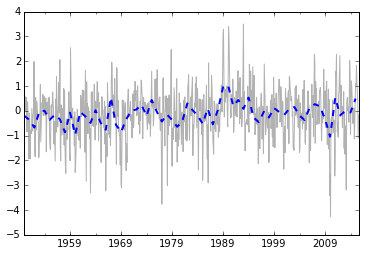

In [37]:
AO_mm = AO.resample("A")
AO.plot(style='k-', alpha = 0.3)
AO_mm.plot(style='b--', linewidth =2)

In [38]:
aonao['mon'] = aonao.index.month
aonao

,AO,NAO,mon
1950-01,-0.060310,0.920000,1
1950-02,0.626810,0.400000,2
1950-03,-0.008127,-0.360000,3
1950-04,0.555100,0.730000,4
1950-05,0.071577,-0.590000,5
1950-06,0.538570,-0.060000,6
1950-07,-0.802480,-1.260000,7
...,...,...,...
2015-03,1.837400,1.449700,3
2015-04,1.215700,0.725350,4


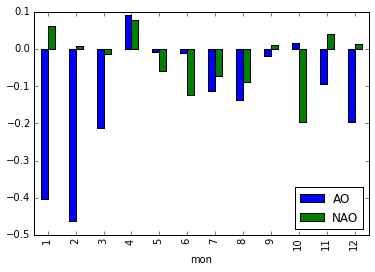

In [39]:
monmean = aonao['1950':'2013'].groupby('mon').aggregate(mean)
monmean.plot(kind='bar')

In order to see what is going on there it is useful to look at the box plots for every month:

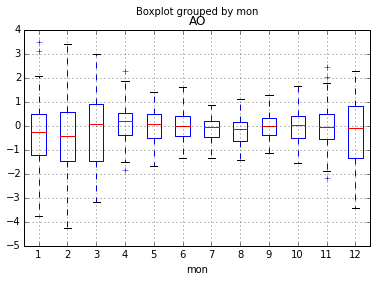

In [40]:
ax = aonao.boxplot(column=['AO'], by='mon')

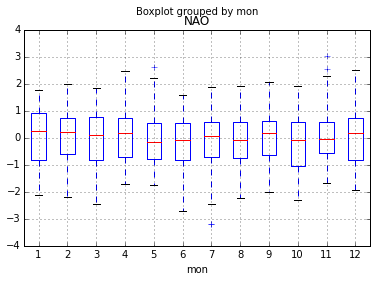

In [41]:
ax = aonao.boxplot(column=['NAO'], by='mon')

While NAO show more or less uniform spread, AO have pronounced seasonal variations, with largest spread during winter months.

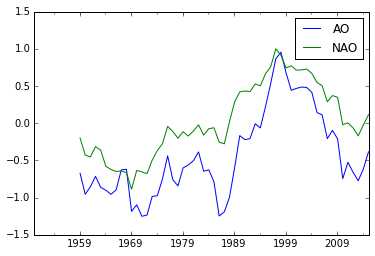

In [42]:
pd.rolling_mean(aonao[['AO','NAO']][aonao.mon==2], window=10).plot()

## F2Py - Use the Fortran performance within Python

In [43]:
%install_ext https://raw.github.com/mgaitan/fortran_magic/master/fortranmagic.py

Installed fortranmagic.py. To use it, type:
  %load_ext fortranmagic


/Users/lsiqueira/anaconda/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension(s)as a python packages.
  "as a python packages.", UserWarning)


In [44]:
%load_ext fortranmagic

/Users/lsiqueira/anaconda/lib/python2.7/site-packages/IPython/utils/path.py:264: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module
  warn("get_ipython_cache_dir has moved to the IPython.paths module")


In [45]:
%%fortran

subroutine old_sin(x, y)
    real, intent(in) :: x
    real, intent(out) :: y

    y = sin(x)

end subroutine old_sin

In [46]:
%timeit old_sin(1.0)

The slowest run took 30.12 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 135 ns per loop


In [47]:
old_sin(30.* np.pi / 180.)

0.5

Lets use Numpy version

In [48]:
import numpy as np
%timeit np.sin(30.* np.pi / 180.)

The slowest run took 28.77 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 796 ns per loop


In [49]:
single(np.sin(30.* np.pi / 180.))

0.5

Even got python documentation for old_sin

In [50]:
#old_sin?
np.sin?


Good old Fortran!

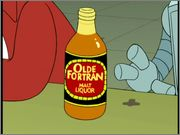

In [51]:
from IPython.display import Image

Image("http://s18.postimg.org/xoghfy291/Olde_Fortran_Malt_Liquor.jpg")